<a href="https://colab.research.google.com/github/samuelmcilrath/forest-fires/blob/main/forestfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Fire Regression - Sam McIlrath and Olivia Creighton

Forest fires are highly detrimental to various communities and ecosystems. Their spread is determined by a variety of factors, including weather, topography, and ground cover. We wanted to determine if meteorological data and data on the ground cover could predict the spread of a forest fire. 

Features include:

**X, Y**: Spatial coordinates within a Monteshino Park map

**Month, day**: "jan" to "dec" and "mon" to "sun"

**FFMC**: Fine Fuel Moisture Code; the amount of moisture in the litter/fuel on the ground; relative measure of ease of ignition and flammability

**DMC**: Duff Moisture Code; the amount of moisture in the top layer of soil

**DC**: Drought Code; the amount of moisture of deeper soil

**ISI**: Initial Spread Index; expected rate of fire spread, based on windspeed and FFMC

**Temp**: Temperature in Celsius degrees

**RH**: Relative humidity in %

**Wind**: Wind speed in km/h

**Rain**: Outside rain in mm/m2

**Area**: Burned area in hectares

FFMC, DMC, and DC according to the FWI (https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import sklearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score


import matplotlib.pyplot as plt
%matplotlib inline

# Set the path to the file you'd like to load
file_path = "C:\MAIN\School\ML\Sem Proj\forest-fires\forestfires.ipynb"

# Load the latest version
forest_fires = pd.read_csv("forestfires_dataset.csv")

print("First 5 records: \n", forest_fires.head())
  

First 5 records: 
    X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


In [80]:
###Transform Data - get splits
forest_fires = forest_fires.drop(columns=['month', 'day']) #drop month and day columns

#get rid of half of 90% of 0 area rows
ff_zeros = forest_fires[forest_fires['area'] == 0]
ff_nonzeros = forest_fires[forest_fires['area'] != 0]
print(ff_nonzeros.shape)
ff_zeros_reduced = ff_zeros.sample(frac=0.05, random_state=42)
forest_fires = pd.concat([ff_nonzeros, ff_zeros_reduced]).reset_index(drop=True)

X = forest_fires.drop(columns=['area', 'X', 'Y'])
Y = forest_fires[['area']]

Y_log = np.log1p(Y) #skewed to 0, apply log 

# Standardize numerical features - this standardizes mean to 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, Y_log, test_size=0.2, random_state=42
)

##note 
#if going with classifier, try to make amounts of nonburn to burn 

(270, 11)


In [81]:
# Plotting the distribution of the target 'area'
plt.figure(figsize=(8, 5))
sns.histplot(Y['area'], bins=30, kde=True)
plt.title('Distribution of Forest Fire Area')
plt.xlabel('Area')
plt.show()

#plot the log-transformed target
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(Y['area']), bins=30, kde=True, color='orange')
plt.title('Log-transformed Distribution of Forest Fire Area')
plt.xlabel('log(Area + 1)')
plt.show()

NameError: name 'sns' is not defined

<Figure size 800x500 with 0 Axes>

In [82]:
# A helper function to evaluate models
def evaluate_model(model, X_test, y_test_log):
    # Predict in log-space then revert transformation
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R²: {r2:.3f}')
    return y_pred

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)
print("Linear Regression Performance:")
lin_y_pred = evaluate_model(lin_reg, X_test, y_test_log)

#Ridge Regression (regularized linear model)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_log)
print("\nRidge Regression Performance:")
ridge_y_pred = evaluate_model(ridge, X_test, y_test_log)

#Lasso Regression 
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train_log)
print("\nLasso Regression Performance:")
lasso_y_pred = evaluate_model(lasso, X_test, y_test_log)

# Neural Network with MLPRegressor
mlp_reg = MLPRegressor(solver ="adam" , hidden_layer_sizes=(100), activation='logistic')

mlp_reg.fit(X_train, y_train_log)
print("\nNeural Network (MLPRegressor) Performance:")
mlp_y_pred = evaluate_model(mlp_reg, X_test, y_test_log)

Linear Regression Performance:
RMSE: 30.913
MAE: 13.421
R²: -0.062

Ridge Regression Performance:
RMSE: 30.913
MAE: 13.420
R²: -0.062

Lasso Regression Performance:
RMSE: 31.145
MAE: 12.945
R²: -0.078

Neural Network (MLPRegressor) Performance:
RMSE: 30.895
MAE: 13.329
R²: -0.061


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
#LINEAR REGRESSION

#Train the model by fitting it to the training data
lr = LinearRegression()
lr = lr.fit(X_train, y_train_log)

lr.coef_

#Test the model by predicting the test results
y_pred = lr.predict(X_test)

#print("Test set targets:\n", y_test_log)
#print("Test set predictions:\n", y_pred)
print("Test set R^2: {:.2f}".format(lr.score(X_test, y_test_log)))

Test set R^2: -0.30


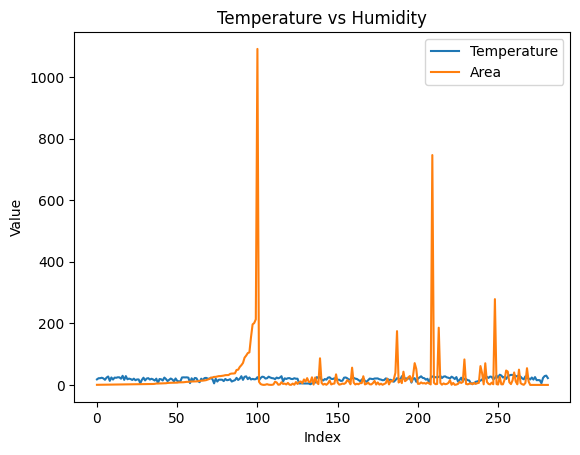

In [84]:
plt.plot(forest_fires.index, forest_fires['temp'], label='Temperature')
plt.plot(forest_fires.index, forest_fires['area'], label='Area')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Temperature vs Humidity')
plt.legend()
plt.show()

In [85]:
#transform to either 0 or 1
Y_bin = Y.copy()
Y_bin['area'] = (Y_bin['area'] != 0).astype(int)


# resplit into training and test sets
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, Y_bin, test_size=0.2, random_state=42
)

In [86]:
#Logistic Regression
log_reg = LogisticRegression(max_iter= 10000)
log_reg.fit(X_train_bin, y_train_bin['area'])  # Just use the 'area' column
y_pred = log_reg.predict(X_test_bin)

# Accuracy
print("Accuracy:", accuracy_score(y_test_bin['area'], y_pred))

#SVM
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train_bin['area'])
y_pred_svm = svm.predict(X_test)


mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train_bin['area'])
y_pred_mlp = mlp.predict(X_test)

print("Neural Net Accuracy:", accuracy_score(y_test_bin['area'], y_pred_mlp))

print("SVM Accuracy:", accuracy_score(y_test_bin['area'], y_pred_svm))

print("Neural Net Accuracy:", accuracy_score(y_test_bin['area'], y_pred_mlp))

Accuracy: 0.9649122807017544
Neural Net Accuracy: 0.9473684210526315
SVM Accuracy: 0.9649122807017544
Neural Net Accuracy: 0.9473684210526315


# Ground vs. Weather
Some of the figures seem to be related to ground condition, while others are related to weather conditions. Do these different sets of factors affect the regression differently?

In [95]:
X_ground = forest_fires.drop(columns=['X','Y','wind','rain','temp','RH','area'])
X_weather = forest_fires.drop(columns=['X','Y','FFMC','DMC','DC','ISI','area'])

print(X.columns)
print(X_ground.columns)
print(X_weather.columns)

X_gscaled = scaler.fit_transform(X_ground)
X_wscaled = scaler.fit_transform(X_weather)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_gscaled, Y_log
)

groundlr = LinearRegression().fit(X_train, y_train_log)

print("Ground training set R^2: {:.2f}".format(newlr.score(X_train, y_train_log)))
print("Ground test set R^2: {:.2f}".format(newlr.score(X_test, y_test_log)))

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_wscaled, Y_log
)

groundlr = LinearRegression().fit(X_train, y_train_log)

print("Weather training set R^2: {:.2f}".format(newlr.score(X_train, y_train_log)))
print("Weather test set R^2: {:.2f}".format(newlr.score(X_test, y_test_log)))

#Somehow make a function that displays each combo of factors against each other

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')
Index(['FFMC', 'DMC', 'DC', 'ISI'], dtype='object')
Index(['temp', 'RH', 'wind', 'rain'], dtype='object')
Ground training set R^2: -0.06
Ground test set R^2: -0.05
Weather training set R^2: -0.05
Weather test set R^2: 0.02


What if it fits better as a polynomial?

In [104]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

X_poly = PolynomialFeatures(degree=8).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y_log)
lr_poly = LinearRegression().fit(X_train, y_train)
print("Polynomial training set R^2: {:.2f}".format(lr_poly.score(X_train, y_train)))
print("Polynomial test set R^2: {:.2f}".format(lr_poly.score(X_test, y_test)))

Polynomial training set R^2: 0.99
Polynomial test set R^2: -196119.28


A liiiiiittle overfit

# to do:
SVR

In [98]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)